# Exploratory Data Analysis

**We will use the star rating system as the reference for understanding the sentiment in customer reviews. This will allow a system in which the customer only submits a text review and the model assigns a rating, hence reducing reliance on human generated star reviews and shifting to reliance on human verbal expression.** 

**This should reduce the prevalence of conflicting reviews (high star to negative sentiment, or vice versa). This means we will explore assuming the ML problem will be multiclass classification for text sentiment analysis.**


In [1]:
import os
os.chdir('/home/clementejasonfortuna/workspace/705.603Portfolio/Multimodal-Analysis/analysis')

from collections import deque
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from multiprocessing import Pool
from itertools import repeat
import time

from Helpers import preprocess, tokentext2seqs

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk
import contractions
import string


2024-04-20 10:12:59.388961: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-20 10:13:00.242136: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
pd.set_option('display.max_columns', None)  # None or 1000
pd.set_option('display.max_rows', 10)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199

**Ingest the data**

In [3]:
df = pd.read_csv('../data/amazon_movie_reviews.csv')

/tmp/ipykernel_85541/1706385969.py:1: DtypeWarning: Columns (18,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/amazon_movie_reviews.csv')


In [16]:
for col, dtyp in zip(df.columns, df.dtypes):
    print('{}  {}'.format(col, dtyp))


Unnamed: 0  int64
rating  float64
review_title  object
text  object
images_x  object
asin  object
parent_asin  object
user_id  object
timestamp  int64
helpful_vote  int64
verified_purchase  bool
main_category  object
movie_title  object
subtitle  object
average_rating  float64
rating_number  float64
features  object
description  object
price  object
images_y  object
videos  object
store  object
categories  object
details  object
bought_together  float64
author  object


**We are interested in *rating* and *text*.**

**scan for bad entries**

In [10]:
df.isna().sum()

Unnamed: 0               0
rating                   0
review_title           127
text                   149
images_x                 0
                    ...   
store               610148
categories          542290
details                  0
bought_together    1000000
author              999882
Length: 26, dtype: int64

**There are some *NaN* in the *text* column. The preprocessing pipeline must eliminate these rows.**

In [13]:
df.shape

(1000000, 26)

**The dataset is very large.  Preprocessing and training will need to reduce operation complexity and leverage parallelization.**

In [8]:
df[df.duplicated('text')].shape

(171303, 26)

**There are a significant number of duplicates.  Preprocessing must eliminate these as well.**

**We will examine the distibution of star ratings:**

In [23]:
df2 = df.drop_duplicates(subset=['text'])
df2 = df2.loc[df2['text'].notna(), ['rating', 'text']]

In [24]:
for rate in [5.0, 4.0, 3.0, 2.0, 1.0]:
    star = (df2['rating'] == rate).sum() / df2.shape[0]
    print('{} star: {:.3f}'.format(rate, star))

5.0 star: 0.603
4.0 star: 0.172
3.0 star: 0.096
2.0 star: 0.054
1.0 star: 0.075


**5 star ratings comprise %60.3 of all ratings.  The model should achieve an accuracy beyond this, to demonstrate surpassing any trivial solution.**

**Preprocessing must also one-hot-encode the ratings.**

**We will analyze the lengths of text entries. To do this we will introduce the normalizing/stemming/tokenizing function, which will be used in both model_analysis.ipynb and the deployed system:**

In [30]:
def get_proccorpus(dfproc):
    """
    Get a normalized, stemmed, tokenized form of a corpus of text.
    
    parameters:
    corpus (list of str): The text corpus
    
    returns:
    tokentext (list of [str]): The tokenized corpus
    proctext (list of str): The tokenized corpus with word re-joined
    ratings (list of float): The star ratings
    """
    corpus = dfproc['text'].to_list()
    ratings = dfproc['rating'].to_list()
    with Pool(14) as pool:  # see helper
        result = pool.starmap(preprocess, zip(corpus, ratings))
    
    df = pd.DataFrame(result, columns = ['tokentext', 'proctext', 'rating'])
    tokentext = df['tokentext'].to_list()
    proctext = df['proctext'].to_list()
    ratings = df['rating'].to_list()
    
    return (tokentext, proctext, ratings)
        

In [26]:
result = get_proccorpus(df2)

mean #tokens: 28.18695034125904
max #tokens: 3459


(array([1.64231e+05, 1.91288e+05, 1.30240e+05, 7.75230e+04, 4.97090e+04,
        3.47140e+04, 2.59120e+04, 2.00460e+04, 1.59690e+04, 1.29370e+04,
        1.05440e+04, 8.83200e+03, 7.46700e+03, 6.48400e+03, 5.56600e+03,
        4.85400e+03, 4.23000e+03, 3.85600e+03, 3.42800e+03, 3.06400e+03,
        2.75000e+03, 2.58600e+03, 2.29100e+03, 2.13900e+03, 2.08300e+03,
        1.86600e+03, 1.70900e+03, 1.59700e+03, 1.49200e+03, 1.40500e+03,
        1.30300e+03, 1.23000e+03, 1.11800e+03, 1.14200e+03, 9.94000e+02,
        1.00500e+03, 9.39000e+02, 9.39000e+02, 8.76000e+02, 8.47000e+02,
        7.45000e+02, 7.32000e+02, 7.13000e+02, 6.51000e+02, 6.40000e+02,
        5.91000e+02, 6.56000e+02, 5.23000e+02, 5.30000e+02, 5.24000e+02,
        5.19000e+02, 4.80000e+02, 4.32000e+02, 4.75000e+02, 3.84000e+02,
        3.91000e+02, 3.90000e+02, 3.86000e+02, 3.49000e+02, 3.44000e+02,
        2.90000e+02, 3.29000e+02, 2.87000e+02, 2.74000e+02, 2.28000e+02,
        2.43000e+02, 2.49000e+02, 2.21000e+02, 1.89

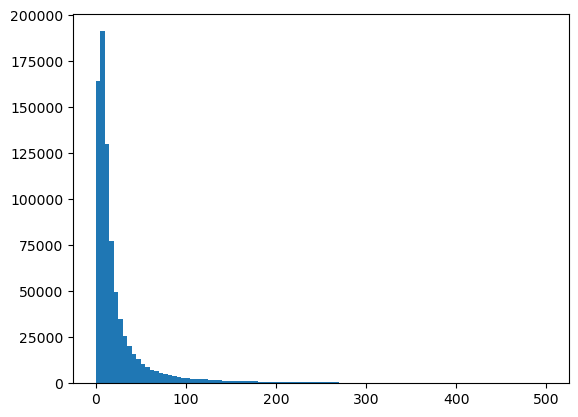

In [29]:
lens = deque()
for item in result[0]:
    lens.append(len(item))
leans = np.array(lens)

print('mean #tokens: {}'.format(np.mean(lens)))
print('max #tokens: {}'.format(np.max(lens)))
plt.hist(lens, bins=100, range=[0, 500])

**Though there can be over 1000 tokens in a review, we will limit the input size to 100 tokens.  This will capture most of the entries and reduce computational requirements.**

## Summary

**Preprocessing must include the following:**
* **Elimination of NaN rows.**
* **Elimination of duplicate text reviews.**
* **One hot encoding of ratings.**
* **Complexity reduction.**
* **Input size limit to 50 tokens.**

**Lastly, the goal for the accuracy metric must be exceeding %60.3.**